In [2]:
import pickle
from PIL import Image
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [3]:
!ls

atlas_hash.pickle
dense.jpg
dense.npy
dense_to_normal-texture.ipynb
experiments.ipynb
human_IUV.jpg
human.jpg
model_image.jpg
normal2atlas_512_200.pickle
normal_faces.pickle
normal.pickle
normal_texture.jpg
normal-texture-to-atlas-texture-in-torch-tensor-Copy1.ipynb
normal-texture-to-atlas-texture-in-torch-tensor.ipynb
normal-texture-to-atlas-texture.ipynb
parts_list_ids.pickle
UV_Processed.mat


In [4]:
with open("./normal.pickle", "rb") as f:
    normal_hash = pickle.load(f)

In [5]:
type(normal_hash)

dict

In [6]:
len(list(normal_hash.keys()))

6890

In [7]:
normal_hash[0]

[[0.3716000020503998, 0.8810999989509583]]

In [8]:
with open("./normal_faces.pickle", "rb") as f:
    normal_faces = pickle.load(f)

In [9]:
type(normal_faces)
len(normal_faces)

13776

In [10]:
normal_tex = np.asarray(Image.open("./normal_texture.jpg"))

In [11]:
normal_tex.shape

(512, 512, 3)

In [12]:
h, w, _ = normal_tex.shape

In [13]:
vertex_tex = {}

In [14]:
for k, v in normal_hash.items():
    # There may be multiple candidates for one vertex, but the texture considers them the same and uses the first candidate.
    vertex_tex[k] = normal_tex[int(h - v[0][1] * (h - 1)), int(v[0][0] * (w - 1)), :]

In [15]:
atlas_size = 200

In [16]:
alp_uv = loadmat("./UV_Processed.mat")

In [17]:
alp_uv.keys()

dict_keys(['__header__', '__version__', '__globals__', 'All_FaceIndices', 'All_Faces', 'All_U', 'All_U_norm', 'All_V', 'All_V_norm', 'All_vertices'])

In [18]:
# (13774,), array([ 1,  1,  1, ..., 24, 24, 24], dtype=uint8)
FaceIndices = np.array(alp_uv['All_FaceIndices']).squeeze()
FacesDensePose = alp_uv['All_Faces'] - 1  # (13774, 3)
# (7829,), array([0.02766012, 0.02547753, 0.2280528 , ..., 0.55260428, 0.54398063, 0.00275962])
U_norm = alp_uv['All_U_norm'].squeeze()
V_norm = alp_uv['All_V_norm'].squeeze()
# (7829,), array([ 607,  608,  707, ..., 3494, 3495, 3500], dtype=uint32)
All_vertices = alp_uv['All_vertices'][0]

In [19]:
def get_list_ids_by_parts(parts_num):
    """
    parts_num = 1 # 1 ~ 24 24 in total, (background 0)
    """

    FaceIndicesNow = np.where(FaceIndices == parts_num)
    FacesNow = FacesDensePose[FaceIndicesNow]  # (1284, 3)
    parts_list_ids = np.unique(FacesNow.flatten())

    return parts_list_ids

In [20]:
atlas_hash = {}
for  parts_num  in  range ( 1 , 25 ):
    parts_list_ids = get_list_ids_by_parts(parts_num)
    for  u , v , ver  in  zip (
        list(
            U_norm[parts_list_ids]), list(
            V_norm[parts_list_ids]), list(
            All_vertices[parts_list_ids])):
        if (ver - 1) in atlas_hash:
            atlas_hash[ver - 1].append([parts_num, u, v])
        else:
            atlas_hash[ver - 1] = [[parts_num, u, v]]

In [21]:
def mapping_to_each_atlas_parts(vertex_tex, parts_num):
    """
    Function to convert normal texture into each part of atlas texture.
    params:
    vertex_tex: Stores the texture for each point of the SMPL model.
    parts_num: The number of the parts. 1 ~ 24.
    """
    tex = np.zeros((atlas_size, atlas_size, 3))
    tex_ex = np.zeros((atlas_size, atlas_size))

    for k, v in atlas_hash.items():
        for t in v:
            if  t [ 0 ] ==  parts_num :
                tex[int(t[1] * (atlas_size - 1)), (atlas_size - 1) -
                    int(t[2] * (atlas_size - 1)), :] = vertex_tex[k]
                
                tex_ex[int(t[1] * (atlas_size - 1)),
                       (atlas_size - 1) - int(t[2] * (atlas_size - 1))] = 1

    return tex / 255, tex_ex

In [22]:
atlas_texture = np.zeros((24, atlas_size, atlas_size, 3))
atlas_ex = np.zeros((24, atlas_size, atlas_size))

In [23]:
for  i  in  range ( 24 ):
            atlas_texture[i], atlas_ex[i] = mapping_to_each_atlas_parts(vertex_tex, parts_num=i + 1)

In [24]:
atlas_texture.shape

(24, 200, 200, 3)

In [25]:
atlas_ex.shape

(24, 200, 200)

In [26]:
with open("normal2atlas_512_200.pickle", mode='rb') as f:
    mapping_relation = pickle.load(f)

In [27]:


painted_atlas_tex = np.copy(atlas_texture)
for relation in mapping_relation:
    new_tex = normal_tex[relation[3], relation[4]]
    painted_atlas_tex[relation[2], relation[0], relation[1]] = new_tex / 255
   

In [28]:
painted_atlas_tex.shape

(24, 200, 200, 3)

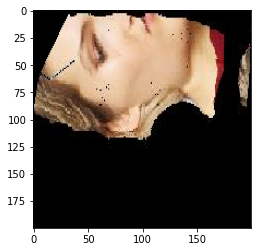

In [30]:
plt.imshow(painted_atlas_tex[23])